### 필터링

* 필요한 정보만 통과시키고 원치 않는 정보는 걸러내는 작업


* 주파수 공간 필터링
   * 주파수 공간으로의 변환 필요
   

* 공간적 필터링
   * 영상의 픽셀값을 직접 이용 - 대상 좌표의 픽셀값과 주변 픽셀 값을 동시에 이용
   * 마스크 연산을 이용 (kernel, window, template)
   
   
* **마스크의 형태와 값에 따라 필터의 역할이 결정됨**
   * 마스크의 정중앙 위치를 **anchor**라고 함 (연산이 적용되는 위치)
   * ex 에지 검출, 잡음 제거, 영상을 부드럽게/날카롭게 만들기
   
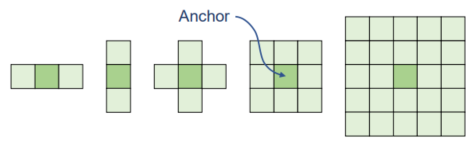

3x3 크기의 마스크를 이용한 공간적 필터링

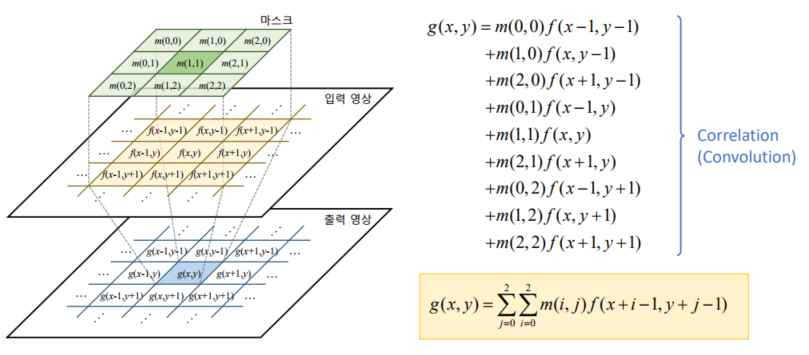

**최외곽 픽셀 처리**

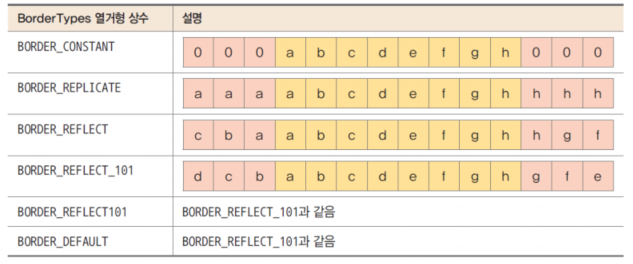

#### 기본적인 2D 필터링 코드

cv2.filter2D(src, ddepth, kernel, dst=None, anchor=None, delta=None, borderType=None) -> dst

* ddepth : 출력 영상의 데이터 타입 (-1을 지정하면 src와 같은 타입의 영상 생성)
* kernel : 필터 마스크 행렬. 실수형
* anchor : 고정점의 위치. (-1, -1)을 사용하면 필터 중앙을 고정점으로 사용
* delta : 추가적으로 더할 값
* borderType : 최외곽 픽셀 확장 방식


### 블러링

#### 평균값 필터

* 영상의 특정 좌표값을 주변 픽셀 값들의 산술 평균으로 설정


* **픽셀들 간의 그레이스케일 값 변화가 줄어들어 날카로운 에지가 무뎌지고, 영상에 있는 잡음들이 사라지는 효과**
   * 마스크 크기가 클 수록 평균 값 필터 결과는 부드러워 지지만, 연산량이 증가
   

* **가까운 픽셀, 멀리 있는 픽셀이 같은 가중치를 사용하여 평균을 계산하는 단점** => 멀리 있는 픽셀의 영향을 받을 수 있음

#### 평균값 필터링 함수 코드

cv2.blur(src, ksize, dst=None, anchor=None, borderType=None) -> dst

* ksize : 평균값 필터 크기 (weight, height)형태의 튜플
* 결과 영상 dst는 입력 영상과 같은 크기, 같은 타입

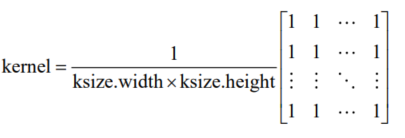

In [2]:
import sys
import numpy as np
import cv2

src = cv2.imread('C:/Users/ky_moon/Desktop/vision/ch04/rose.bmp', cv2.IMREAD_GRAYSCALE)

if src is None:
    print('Image load failed!')
    sys.exit()

cv2.imshow('src', src)

for ksize in (3, 5, 7):
    dst = cv2.blur(src, (ksize, ksize))  # 3x3, 5x5, 7x7

    desc = 'Mean: {}x{}'.format(ksize, ksize)
    cv2.putText(dst, desc, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                1.0, 255, 1, cv2.LINE_AA)

    cv2.imshow('dst', dst)
    cv2.waitKey()

cv2.destroyAllWindows()

#### 가우시안 필터

* 가까운 픽셀은 큰 가중치를, 멀리 있는 픽셀은 작은 가중치를 사용하여 평균을 계산

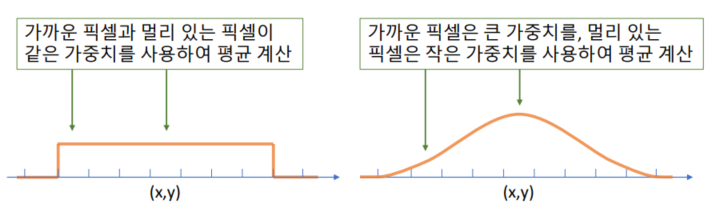

#### 가우시안 필터링 코드

cv2.GaussianBlur(src, ksize, sigmaX, dst=None, sigmaY=None, borderType=None) -> dst

* src : 입력 영상. 각 채널 별로 처리됨
* dst : 출력 영상
* ksize : 가우시안 커널의 크기. (0, 0)으로 지정하면 자동으로 sigma값을 이용해 결정함
* sigmaX : x방향 sigma
* sigmaY : 0이면 sigmaX와 동일하게 설정

In [3]:
import sys
import numpy as np
import cv2


src = cv2.imread('C:/Users/ky_moon/Desktop/vision/ch04/rose.bmp', cv2.IMREAD_GRAYSCALE)

dst = cv2.GaussianBlur(src, (0, 0), 3)
dst2 = cv2.blur(src, (7, 7))

cv2.imshow('src', src)
cv2.imshow('dst', dst)
cv2.imshow('dst2', dst2)
cv2.waitKey()

cv2.destroyAllWindows()

In [6]:
import sys
import numpy as np
import cv2


src = cv2.imread('C:/Users/ky_moon/Desktop/vision/ch04/rose.bmp', cv2.IMREAD_GRAYSCALE)

if src is None:
    print('Image load failed!')
    sys.exit()

cv2.imshow('src', src)

for sigma in range(1, 6):
    # sigma 값을 이용하여 가우시안 필터링, sigma가 커질 수록 영상이 부드러워지는 효과가 커짐 (픽셀의 변화가 정규화되어 블러 처리 되는거처럼 보임)
    dst = cv2.GaussianBlur(src, (0, 0), sigma)

    desc = 'sigma = {}'.format(sigma)
    cv2.putText(dst, desc, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                1.0, 255, 1, cv2.LINE_AA)

    cv2.imshow('dst', dst)
    cv2.waitKey()

cv2.destroyAllWindows()

### 샤프닝 : 언샤프 마스크 필터

* 부드러운 영상을 이용하여 상대적으로 **날카로운(에지가 강조된)** 영상 생성
   * 에지 근방에서 contrast가 증가
   
   
* 영샹을 특정 방향으로 봤을때 픽셀값이 변화하는 구간 표현 (입력 영상의 에지 부분에서의 그레이스케일 값 변화)
   * (1, 1) : 기존 영상 / (1, 2) : 가우시안 필터가 적용되어 부드러워짐 / (2, 1) : 기존 영상 픽셀 - 가우시안 필터가 적용된 픽셀 / (2, 2) : 언샤프 마스크
   * **에지 부분에 해당되는 픽셀에서 보다 큰 양수/음수 값**을 갖게되고, 평탄한 영역은 0에 가깝게

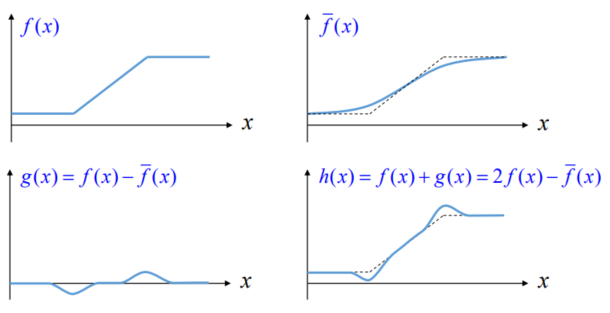


* 실제로는 영상에 대한 이차 미분을 이용하는 방법을 많이 사용함

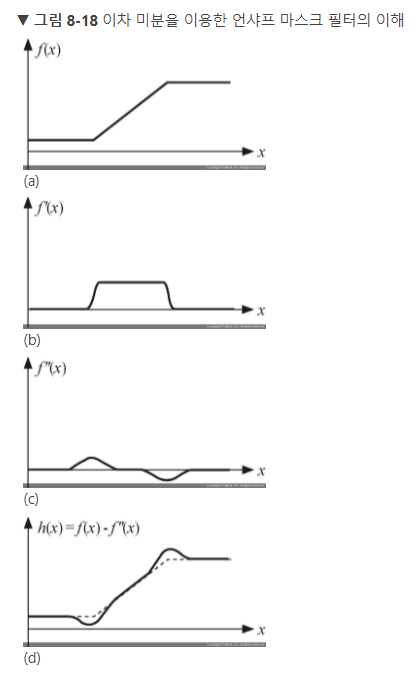

* 수식으로 표현

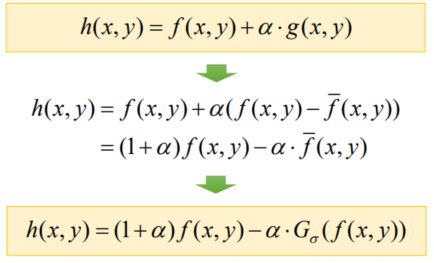

* h : 언샤프 마스크가 적용된 영상 
* f : 입력 영상 
* g : 입력 영상 - 부드러워진 영상(f bar) 
* a를 통해 샤프닝 정도를 조절

In [7]:
import sys
import numpy as np
import cv2

src = cv2.imread('C:/Users/ky_moon/Desktop/vision/ch04/rose.bmp', cv2.IMREAD_GRAYSCALE)

if src is None:
    print('Image load failed!')
    sys.exit()

blr = cv2.GaussianBlur(src, (0, 0), 2)  # 부드러워진 영상 g
dst = np.clip(2.0*src - blr, 0, 255).astype(np.uint8)  # a=1로 설정

cv2.imshow('src', src)
cv2.imshow('dst', dst)
cv2.waitKey()

cv2.destroyAllWindows()

In [9]:
import sys
import numpy as np
import cv2

src = cv2.imread('C:/Users/ky_moon/Desktop/vision/ch04/rose.bmp')

if src is None:
    print('Image load failed!')
    sys.exit()

src_ycrcb = cv2.cvtColor(src, cv2.COLOR_BGR2YCrCb)

src_f = src_ycrcb[:, :, 0].astype(np.float32) 
blr = cv2.GaussianBlur(src_f, (0, 0), 2.0)  # 부드러워진 영상 g
src_ycrcb[:, :, 0] = np.clip(2. * src_f - blr, 0, 255).astype(np.uint8)  # a=1로 설정

dst = cv2.cvtColor(src_ycrcb, cv2.COLOR_YCrCb2BGR)

cv2.imshow('src', src)
cv2.imshow('dst', dst)
cv2.waitKey()

cv2.destroyAllWindows()

### 잡음

영상의 픽셀값에 추가되는 원치 않는 형태의 신호

#### 미디언 필터

주변 픽셀들의 값을 정렬하여 그 중앙값으로 픽셀 값을 대체

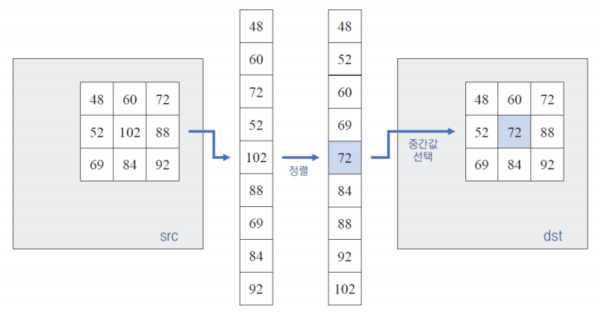

#### 미디언 필터링 코드

cv2.medianBlur(src, ksize, dst=None) -> dst

* src : 각 채널 별로 분리되는 입력 영상
* ksize : 커널 크기. 1보다 큰 홀수

In [10]:
import sys
import numpy as np
import cv2

src = cv2.imread('C:/Users/ky_moon/Desktop/vision/ch04/noise.bmp', cv2.IMREAD_GRAYSCALE)

if src is None:
    print('Image load failed!')
    sys.exit()

dst = cv2.medianBlur(src, 3)

cv2.imshow('src', src)
cv2.imshow('dst', dst)
cv2.waitKey()

cv2.destroyAllWindows()

#### 양방향 필터

**edge preserving** noise removal filter

* 영상의 가우시안 노이즈는 줄이면서 경계는 뚜렷하게 보이도록 처리 (영상 내 객체를 보다 선명하게 표현)


* 기준 픽셀과 이웃 픽셀과의 거리, 픽셀 값의 차이를 함께 고려하여 블러링의 정도를 조절


* 평균 값, 가우시안 필터가 에지 부근에서 픽셀 값을 평탄하게 만드는 문제를 해결
   * 평탄한 부분은 가우시안 필터로, 에지 부분이면 가우시안의 일부분만 가져와 필터링을 적용하여 에지 보존

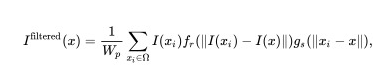

* 현재 픽셀값과 인접 픽셀값 차이가 클수록 가우시안 분포함수에서 0에 가까운 값으로 수렴하여 블러링 값이 작아짐 (픽셀값 차이가 큰 부분은 블러링 지양)

#### 양방향 필터링 코드

cv2.bilateralFilter(src, d, sigmaColor, sigmaSpace, dst=None, borderType=None) -> dst

* src : 1/3채널의 입력 영상
* d : 필터링에 사용될 이웃 픽셀의 거리(지름), -1을 입력하면 sigmaSpace값에 의해 자동으로 결정
* sigmaColor : 색 공간에서 필터의 표준 편차
* sigmaSpace : 좌표 공간에서 필터의 표준 편차

In [13]:
import sys
import numpy as np
import cv2

src = cv2.imread('C:/Users/ky_moon/Desktop/vision/ch04/lenna.bmp')

if src is None:
    print('Image load failed!')
    sys.exit()

dst = cv2.bilateralFilter(src, -1, 10, 5)

cv2.imshow('src', src)
cv2.imshow('dst', dst)
cv2.waitKey()

cv2.destroyAllWindows()


In [15]:
# 카툰 필터 카메라

import sys
import numpy as np
import cv2


def cartoon_filter(img):
    h, w = img.shape[:2]
    img2 = cv2.resize(img, (w//2, h//2))  # 작은 형태로

    blr = cv2.bilateralFilter(img2, -1, 20, 7)
    edge = 255 - cv2.Canny(img2, 80, 120)  # 칼라 영상을 그레이스케일로 변환하여 에지 검출, 0~255의 값을 가지기 때문에 반전시키는 효과
    edge = cv2.cvtColor(edge, cv2.COLOR_GRAY2BGR)  # 칼라 형태

    dst = cv2.bitwise_and(blr, edge)  # 비트 단위의 AND 논리 연산 수행
    dst = cv2.resize(dst, (w, h), interpolation=cv2.INTER_NEAREST) # 원래 형태로, interpolation을 지정하지 않으면 이미지 크기를 복원하는 과정에서 약간의 블러링 효과 o

    return dst


def pencil_sketch(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blr = cv2.GaussianBlur(gray, (0, 0), 3)  # 에지 부근의 급격한 변화가 smooth하게 변함
    dst = cv2.divide(gray, blr, scale=255)  # gray를 blr로 나누고 255를 곱함(에지 근방의 픽셀값은 0에 가깝게, 평탄한 영역은 255)
    return dst


cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print('video open failed!')
    sys.exit()

cam_mode = 0

while True:
    ret, frame = cap.read()

    if not ret:
        break

    if cam_mode == 1:
        frame = cartoon_filter(frame)
    elif cam_mode == 2:
        frame = pencil_sketch(frame)
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)

    cv2.imshow('frame', frame)
    key = cv2.waitKey(1)

    if key == 27:
        break
    elif key == ord(' '):
        cam_mode += 1
        if cam_mode == 3:
            cam_mode = 0


cap.release()
cv2.destroyAllWindows()